In the last model, I cleaned up the validation and test set. The validation didn't mirror the training set like it did previously. The accuracy on validation and test sets were closer. In this model, I will add a significant number of augmented images to see the results.

In [1]:
%load_ext autoreload
%autoreload 2
import project_utils_multi

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
# tf.get_logger().setLevel('INFO')
# tf.autograph.set_verbosity(1)
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device. Error.')
    pass

from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from random import randint
import numpy as np

RANDOM_SEED = 0
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
EPOCHS = 50
LEARNING_RATE = 0.0001
ES_PATIENCE = 20
ES_RESTORE_WEIGHTS = True
PLAY_VIDEOS = False

In [2]:
df_train = project_utils_multi.load_image_dataframes('./data/train/', 'annotations.json')
display(df_train)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,152.0,140.0,397.0,346.0
1,00002.jpg,1.0,144.0,140.0,403.0,345.0
2,00003.jpg,1.0,142.0,138.0,402.0,346.0
3,00004.jpg,1.0,144.0,140.0,405.0,344.0
4,00005.jpg,1.0,141.0,140.0,407.0,344.0
...,...,...,...,...,...,...
35993,35994.jpg,0.0,0.0,0.0,0.0,0.0
35994,35995.jpg,0.0,0.0,0.0,0.0,0.0
35995,35996.jpg,0.0,0.0,0.0,0.0,0.0
35996,35997.jpg,0.0,0.0,0.0,0.0,0.0


In [3]:
df_validation = project_utils_multi.load_image_dataframes('./data/validation/', 'annotations.json')
display(df_validation)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,439.0,600.0,630.0,804.0
1,00002.jpg,1.0,280.0,466.0,467.0,650.0
2,00003.jpg,1.0,204.0,455.0,409.0,636.0
3,00004.jpg,1.0,218.0,380.0,412.0,538.0
4,00005.jpg,1.0,220.0,405.0,423.0,568.0
...,...,...,...,...,...,...
305,00306.jpg,0.0,0.0,0.0,0.0,0.0
306,00307.jpg,0.0,0.0,0.0,0.0,0.0
307,00308.jpg,0.0,0.0,0.0,0.0,0.0
308,00309.jpg,0.0,0.0,0.0,0.0,0.0


In [4]:
df_test = project_utils_multi.load_image_dataframes('./data/test/', 'annotations.json')
display(df_test)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,220.0,252.0,411.0,437.0
1,00002.jpg,1.0,217.0,241.0,402.0,432.0
2,00003.jpg,1.0,229.0,252.0,416.0,443.0
3,00004.jpg,1.0,243.0,317.0,425.0,487.0
4,00005.jpg,1.0,274.0,332.0,457.0,510.0
...,...,...,...,...,...,...
219,00220.jpg,0.0,0.0,0.0,0.0,0.0
220,00221.jpg,0.0,0.0,0.0,0.0,0.0
221,00222.jpg,0.0,0.0,0.0,0.0,0.0
222,00223.jpg,0.0,0.0,0.0,0.0,0.0


In [5]:
train_datagen= project_utils_multi.create_data_generators(df_train, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/train/', seed=RANDOM_SEED)
validation_datagen = project_utils_multi.create_data_generators(df_validation, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/validation/', seed=RANDOM_SEED)
test_datagen = project_utils_multi.create_data_generators(df_test, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/test/', seed=RANDOM_SEED)
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(train_datagen, num_to_iter=250))
    display(project_utils_multi.play_images_from_sequence_datagen(validation_datagen, num_to_iter=1))
    display(project_utils_multi.play_images_from_sequence_datagen(test_datagen, num_to_iter=1))

In [6]:
pos_neg = project_utils_multi.get_negative_positive_count('./data/train/', 'annotations.json')
print('Total Examples: ', pos_neg['positive'] + pos_neg['negative'])
print('Total positive: ', pos_neg['positive'])
print('Total negative: ', pos_neg['negative'])
print('Train positive: ', train_datagen.get_positive_count())
print('Train negative: ', train_datagen.get_negative_count())
print('Validation positive: ', validation_datagen.get_positive_count())
print('Validation negative: ', validation_datagen.get_negative_count())
print('Test positive: ', test_datagen.get_positive_count())
print('Test negative: ', test_datagen.get_negative_count())

Total Examples:  35998
Total positive:  25398
Total negative:  10600
Train positive:  25398
Train negative:  10600
Validation positive:  262
Validation negative:  48
Test positive:  202
Test negative:  22


In [7]:
vgg = keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=keras.layers.Input(shape=(224, 224, 3)))
vgg.trainable = False

flatten = vgg.output
flatten = keras.layers.Flatten()(flatten)

hidden = keras.layers.Dense(1024, activation='relu')(flatten)

confHead = keras.layers.Dense(1, activation='sigmoid', name='confidence_output')(hidden)
bbHead = keras.layers.Dense(4, activation='linear', name='bounding_output')(hidden)

model = keras.models.Model(inputs=vgg.input, outputs=[confHead, bbHead])
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=opt, metrics=[[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()], [project_utils_multi.IOU_Metric()]])#, run_eagerly=True)


# es = EarlyStopping(monitor='val_bounding_output_iou__metric', mode='max', verbose=1, patience=ES_PATIENCE, restore_best_weights=ES_RESTORE_WEIGHTS)
es = EarlyStopping(monitor='val_bounding_output_loss', mode='min', verbose=1, patience=ES_PATIENCE, restore_best_weights=ES_RESTORE_WEIGHTS)

history = model.fit(train_datagen, 
                    steps_per_epoch=train_datagen.get_length() // BATCH_SIZE,
                    validation_data=validation_datagen, 
                    validation_steps = validation_datagen.get_length() // BATCH_SIZE,
                    epochs=EPOCHS, 
                    callbacks=[es])


Epoch 1/50
562/562 [==============================] - 120s 193ms/step - loss: 76323.6146 - confidence_output_loss: 0.2588 - bounding_output_loss: 76323.3299 - confidence_output_binary_accuracy: 0.6550 - confidence_output_auc: 0.6358 - bounding_output_iou__metric: 0.1692 - val_loss: 16518.3906 - val_confidence_output_loss: 0.0453 - val_bounding_output_loss: 16518.3438 - val_confidence_output_binary_accuracy: 0.9531 - val_confidence_output_auc: 0.9639 - val_bounding_output_iou__metric: 0.3487
Epoch 2/50
562/562 [==============================] - 108s 193ms/step - loss: 28902.2436 - confidence_output_loss: 0.0347 - bounding_output_loss: 28902.2058 - confidence_output_binary_accuracy: 0.9580 - confidence_output_auc: 0.9920 - bounding_output_iou__metric: 0.3184 - val_loss: 14661.3008 - val_confidence_output_loss: 0.0595 - val_bounding_output_loss: 14661.2412 - val_confidence_output_binary_accuracy: 0.9297 - val_confidence_output_auc: 0.9823 - val_bounding_output_iou__metric: 0.4201
Epoch 3/

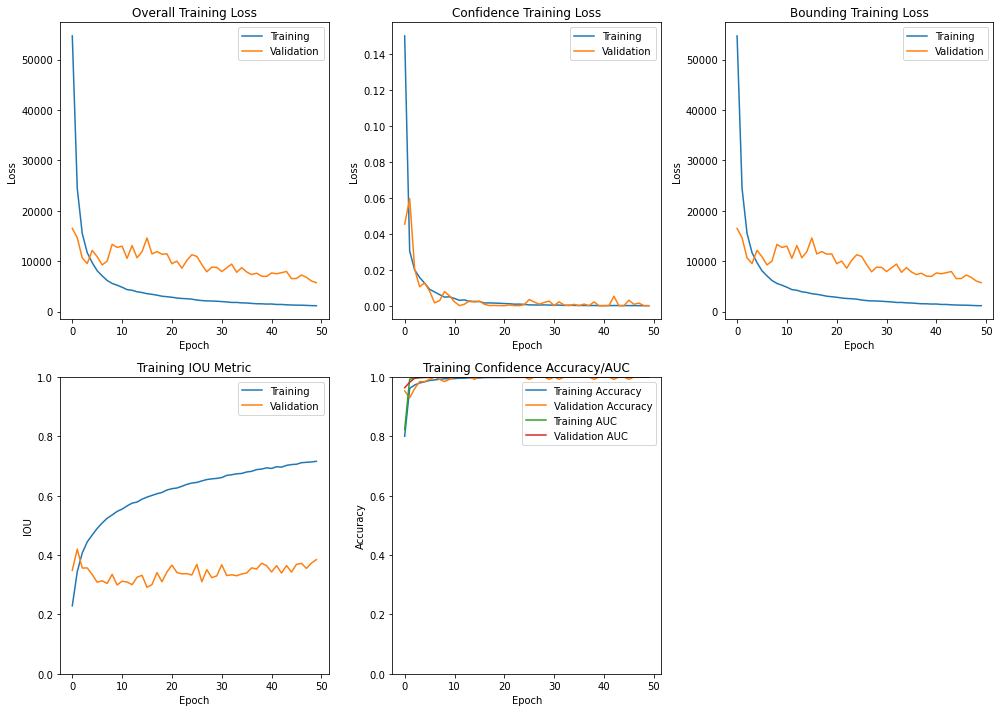

7/7 [==============================] - 1s 181ms/step - loss: 5663.0728 - confidence_output_loss: 0.0035 - bounding_output_loss: 5663.0693 - confidence_output_binary_accuracy: 0.9955 - confidence_output_auc: 1.0000 - bounding_output_iou__metric: 0.4063
Training Loss: 1250.5059814453125
Training IOU: 0.7065886855125427
Validation Loss: 5803.689453125
Validation IOU: 0.38040485978126526
Test Loss: 5663.07275390625
Test IOU: 0.4062879979610443


In [8]:
project_utils_multi.plot_history(history)
train_results = model.evaluate(train_datagen)
validation_results = model.evaluate(validation_datagen)
test_results = model.evaluate(test_datagen)
print('Training Loss: {}\nTraining IOU: {}'.format(train_results[0], train_results[-1]))
print('Validation Loss: {}\nValidation IOU: {}'.format(validation_results[0], validation_results[-1]))
print('Test Loss: {}\nTest IOU: {}'.format(test_results[0], test_results[-1]))
project_utils_multi.write_results('./history.txt', model, history, train_datagen, validation_datagen)

In [9]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(train_datagen, model=model, num_to_iter=100))

In [10]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(validation_datagen, model=model, num_to_iter=1))

In [11]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(test_datagen, model=model, num_to_iter=1))

In [12]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_video('../../data/original/test_videos/hand_signs_webcam.mp4', model=model))

In [13]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_video('../../data/original/test_videos/hand_signs_hand_only.mp4', model=model))

In [14]:
display(project_utils_multi.play_images_from_video('../../data/original/videos/hand_signs_hand_only.mp4', model=model))